In [71]:
from math import ceil, log

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.precision", 16)


In [77]:
class DBMeta(object):
    
    def __init__(self, T, K, Z, B, E, bpe, N, phi=1):
        self.T = T
        self.K = K
        self.Z = Z
        self.B = B
        self.E = E
        self.bpe = bpe
        self.N = N
        self.phi = phi
        if (K == T - 1):
            self.is_tiering = True
        else:
            self.is_tiering = False
        
    def level(self):
        
        return ceil(log((self.N * (self.E / self.B)) + 1, self.T))
    
    def write_cost(self):
        cost = (self.T - 1) * (1 + self.phi) * (self.level() / self.B)
        if (self.is_tiering):
            cost = cost / self.T
        else:
            cost = cost / 2
            
        return cost
    
    def dost_write_cost(self):
         
        return (1 / self.B) * (((self.T - 1) * (self.level() - 1) / (self.K + 1)) + (self.T - 1) / (self.Z + 1))

In [78]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
    
    fsz = 14
    plt.rc('font', size=fsz)
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    
def plot_cost_ratio(df):
    is_tiering = True if df.iloc[-1]['K'] == df.iloc[-1]['T'] - 1 else False
    fig, ax1 = plt.subplots()
    
    color = 'black'
    ax1.set_xlabel('Size Ratio (T)')
    ax1.set_ylabel('Avg ms per Write', color=color)
    ax1.plot(df['T'], df['measured_write_cost'] / (1000), color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    color = 'red'
    ax2 = ax1.twinx()
    ax2.set_ylabel('Model Cost', color=color)
    ax2.plot(df['T'], df['model_write_cost'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    B, E, num_writes = df.iloc[-1][['B', 'E', 'num_writes']]
    title = [
        'Policy: {}'.format('Tiering' if is_tiering else 'Leveling'),
        'Buffer Size: {} MB'.format(B / (1 << 20)),
        'Entry Size: {} KB'.format(E / (1 << 10)),
        'Writes: {}'.format(int(num_writes))
    ]
        
    ax1.set_title('\n'.join(title))
    
    return fig

def read_data(file_path): 
    df = pd.read_csv(file_path)
    df['model_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).write_cost(), axis=1)
    df['dost_write_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).dost_write_cost(), axis=1)
    df['estimated_levels'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['N']).level(), axis=1)
    df['measured_write_cost'] = df['write_time'] / df['num_writes']
    
    return df

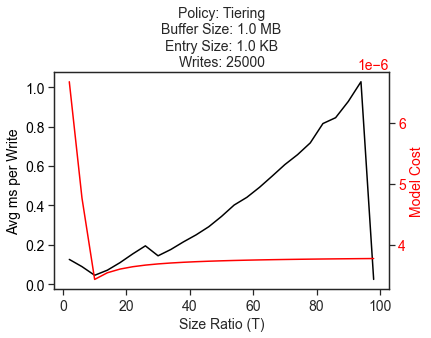

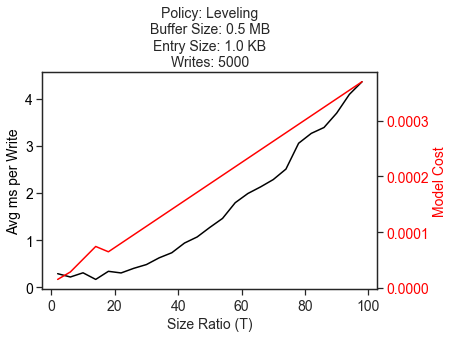

In [79]:
df1 = read_data('../../data/05.csv')
set_style()
fig = plot_cost_ratio(df1)

df2 = read_data('../../data/04.csv')
set_style()
fig = plot_cost_ratio(df2)

In [76]:
df1

,T,K,Z,B,E,bpe,N,write_time,num_writes,non_empty_read_time,num_non_empty_reads,empty_read_time,num_empty_reads,model_write_cost,dost_write_cost,estimated_levels,measured_write_cost
0,2,1,1,1048576,1024,5.0,100000,3154206,25000,-1,0,-1,0,0.0000066757202148,0.0000033378601074,7,126.1682399999999973
1,6,5,5,1048576,1024,5.0,100000,2239624,25000,-1,0,-1,0,0.0000047683715820,0.0000023841857910,3,89.5849599999999953
2,10,9,9,1048576,1024,5.0,100000,1142136,25000,-1,0,-1,0,0.0000034332275391,0.0000017166137695,2,45.6854399999999998
3,14,13,13,1048576,1024,5.0,100000,1785760,25000,-1,0,-1,0,0.0000035422188895,0.0000017711094448,2,71.4304000000000059
4,18,17,17,1048576,1024,5.0,100000,2745160,25000,-1,0,-1,0,0.0000036027696398,0.0000018013848199,2,109.8063999999999965
5,22,21,21,1048576,1024,5.0,100000,3849574,25000,-1,0,-1,0,0.0000036413019354,0.0000018206509677,2,153.9829599999999914
6,26,25,25,1048576,1024,5.0,100000,4872723,25000,-1,0,-1,0,0.0000036679781400,0.0000018339890700,2,194.9089199999999948
7,30,29,29,1048576,1024,5.0,100000,3612730,25000,-1,0,-1,0,0.0000036875406901,0.0000018437703451,2,144.5091999999999928
8,34,33,33,1048576,1024,5.0,100000,4406481,25000,-1,0,-1,0,0.0000037025002872,0.0000018512501436,2,176.2592400000000055
9,38,37,37,1048576,1024,5.0,100000,5374567,25000,-1,0,-1,0,0.0000037143104955,0.0000018571552477,2,214.9826799999999878
